# Proyecto 04 - Informe Final Carrera

Profundiza y ajusta la resolución de tus proyectos: agrega al menos una fuente de datos o prueba un modelo que hasta el momento no hayas aplicado. Elabora un informe final que describa el proceso de toma de decisiones. Sustenta la razón por la cual usaste las librerías y aplicaste los métodos al dataset. Todos tus hallazgos deberán ser comunicados en función de la problemática y las preguntas que buscabas responder.

## Consigna
Te presentamos los pasos a seguir para realizar el proyecto 04.

### 1. Elige tu punto de partida:

- Proyecto 03

### 2. Formula una nueva pregunta, problema o desafío para explorar.

- Se revisarán 3 puntos:
    1. Justificar por qué se consideran 7 pasos en el pasado para realizar una predicción.
    2. ¿El desempeño del modelo mejorará agregando una varible categórica como feature?
    3. ¿Un modelo de Redes Neuronales tendrá mejor desempeño que el modelo final obtenido en el Proyecto 3? 

### Importar librerías ocupadas en el proyecto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from xgboost import plot_importance

### Preparar el Data Set del flujo vehicular para los años 2017, 2081 y 2019


En esta sección se realiza el mismo tratamiento de datos realizado en el Proyecto 3 para obtener la serie de tiempo del flujo vehicular en la estación Illia para Pago en Efectivo de los años 2017, 2018 y 2019, el cual contiene la sumatoria de autos por día ('cantidad_pasos'), y en donde el índice de cada registro es su respectiva fecha.

In [2]:
data_2019 = pd.read_csv('..//Proyecto_3//Datasets//flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('..//Proyecto_3//Datasets//flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('..//Proyecto_3//Datasets//flujo-vehicular-2017.csv', sep =',')

In [3]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
ds_2019 = dataset.resample('D', on = 'fecha').sum()

print(ds_2019.shape)
ds_2019.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


## 2.1 Justificar por qué se consideran 7 pasos en el pasado para realizar una predicción.

### Análisis de frecuencias.

La selección de la cantidad de pasos en el pasado que se utilizarían para la predicción en una serie de tiempo podríamos pensar que la podemos determinar por medio de "prueba y error". Es decir, en una iteración puedo considerar 5 pasos en el pasado como variables predictoras; en otra iteración podría considerar 8 pasos, y así crear un modelo para cada caso, evaluarlo y seleccionar el que ofrezca mejor rendimiento. Este método podría ser utilizado muchas veces por personas que apenas venimos aprendiendo sobre este ámbito de Ciencia de Datos. Puede ser válido, pero la realidad es que consume mucho tiempo.

Un método que me pareció muy útil es útilizar la Transformada Discreta de Fourier, la cual convierte una señal que se encuentra en el dominio del tiempo (como son las series de tiempo) en otra en el dominio de la frecuencia. Así, esta nueva señal en el dominio de la frecuencia, al graficarla nos indicará en qué frecuencias de tiempo los datos podría volverse a repetir.

En el siguiente bloque de código se tiene la implementación de este recurso para realizar un análisis de las frecuencia presentes en la serie, en donde se muestra que la frecuencia de 7 días tiene la mayor amplitud, lo que indica que cierta información se repite cada 7 días, lo cual tiene sentido, en cuestiones de tráfico vehicular, por ejemplo, el tráfico de los lunes se repite a cada semana, que es el intevalo de días que nos indica la serie.

De esta forma se justifca el uso de 7 dias en el pasado para poder prodecir un estado de tiempo con el modelo.

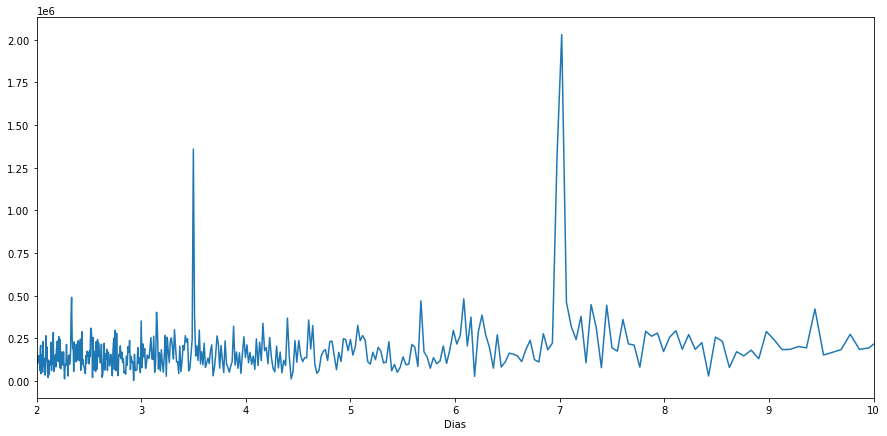

In [4]:
# Obtenemos la cantidad de muestras del DataSet
nobs = len(ds_2019['cantidad_pasos']) 

# Se aplica la Transformada Rápida de Fourier a los datos de la serie para obtener la Tranformada Discreta de Fourier
pasos_ft = np.abs(np.fft.rfft(ds_2019['cantidad_pasos']))

# Se obtienen los centros de frecuencia que se maneja en la serie de tiempo, en este caso 1/Cantidad de Días
pasos_freq = np.fft.rfftfreq(nobs)

# Se pinta el gráfico que representa el comportamiento de la serie en el dominio de la frecuencia
plt.figure(figsize=(15, 7))
plt.plot(1/pasos_freq[2:], pasos_ft[2:])

plt.xlim([2,10])
     
plt.xlabel('Dias')
plt.show()

### Se aplica el tratamiento a la serie para eliminar componentes de tendecia y estacionalidad como se realizó en elproyecto 3

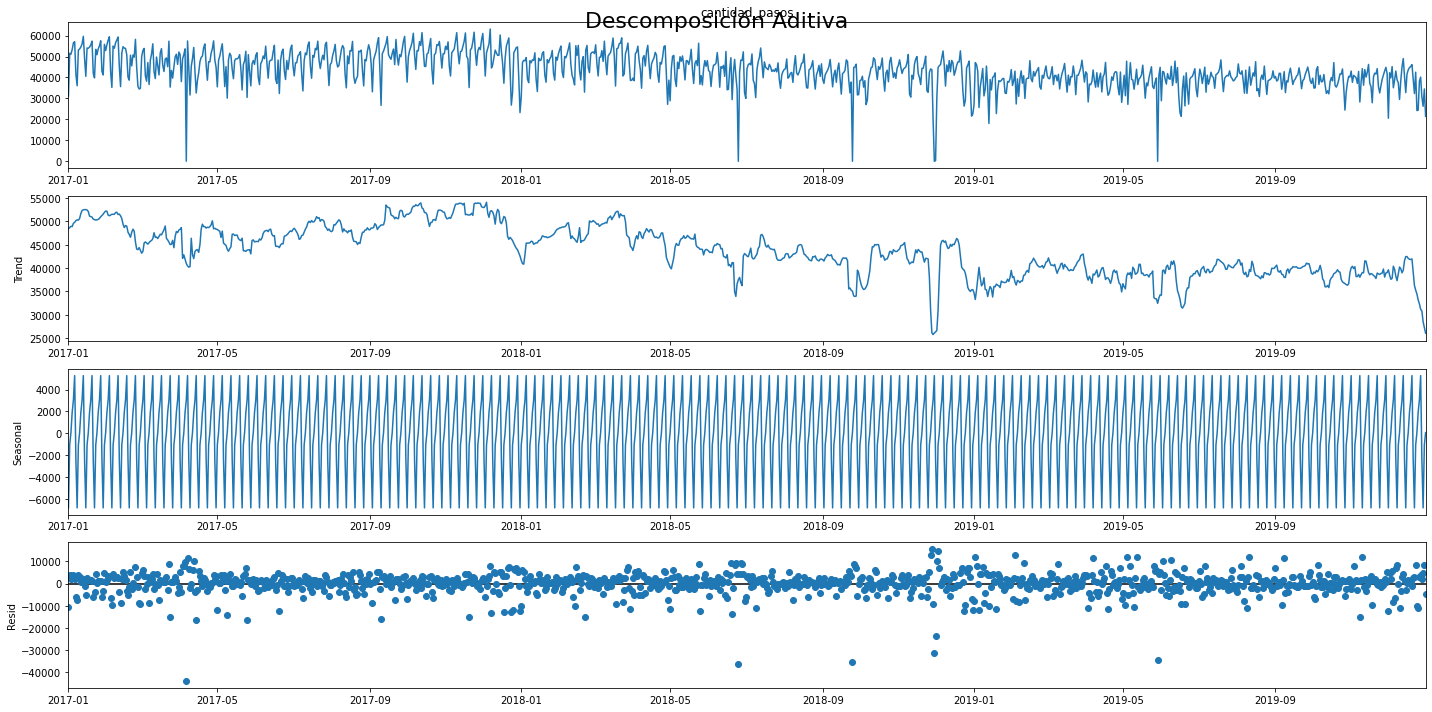

In [5]:
# Se obtienen las componentes de la serie como un modelo aditivo
desc_add_1 = seasonal_decompose(ds_2019.cantidad_pasos, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
desc_add_1.plot().suptitle('Descomposición Aditiva', fontsize=22)

plt.show()

In [6]:
# Se tabulan los datos obtenidos de las componentes para una visualización más cómoda
df_add_1 = pd.concat([desc_add_1.seasonal, desc_add_1.trend, desc_add_1.resid, desc_add_1.observed], axis=1)
df_add_1.columns = ['seas', 'trend', 'resid', 'actual_values']
df_add_1.head()

,seas,trend,resid,actual_values
fecha,,,,
2017-01-01,-6815.221907,48443.346939,-10445.125032,31183.0
2017-01-02,-1063.599295,48696.765306,3934.833989,51568.0
2017-01-03,67.228958,48950.183673,2075.587369,51093.0
2017-01-04,1911.562438,48904.285714,2516.151847,53332.0
2017-01-05,3048.398519,49601.714286,3835.887195,56486.0


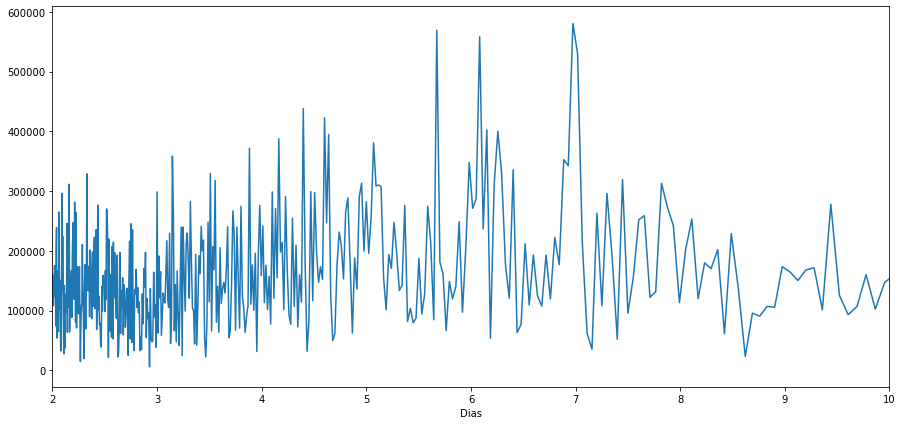

In [7]:
# La columna "resid" contiene la información de la serie sin los componentes de tendencia y estacionalidad
nobs = len(df_add_1['resid'])

# Se aplica la Tranformada Rápida de Fourier para analizar sus frecuencias; se muestra que ya no predomina una frecuencia porque se eliminó la componente de estacionalidad.
pasos_ft = np.abs(np.fft.rfft(df_add_1['resid']))
pasos_freq = np.fft.rfftfreq(nobs)

plt.figure(figsize=(15, 7))
plt.plot(1/pasos_freq[2:], pasos_ft[2:])

plt.xlim([2,10])
    
plt.xlabel('Dias')
plt.show()

In [8]:
# Se utiliza la columna "resid" como nuestra nueva serie, ya que es la serie original, pero sin los componentes de tendencia y estacionalidad que debemos eliminar
ds_2019_est = df_add_1[['resid']].rename(columns = {'resid':'cantidad_pasos'})

ds_2019_est.head()

,cantidad_pasos
fecha,
2017-01-01,-10445.125032
2017-01-02,3934.833989
2017-01-03,2075.587369
2017-01-04,2516.151847
2017-01-05,3835.887195


## Crear ventana de valores con retrasos

In [9]:
# Función que crea una ventana de datos por instancia. Se indica la cantidad de datos que se utilizarán para predecir, la cantidad de valores a predecir y el retraso
def crearVentana(input_width, label_width, shift, data):

    total_window_size = input_width + shift
    label_start = total_window_size - label_width

    input_slice = slice(0, input_width)
    labels_slice = slice(label_start, label_start + label_width)

    inputs = data[input_slice]
    labels = data[labels_slice]
    return inputs, labels

# Funcion que crea el set de datos completo considerando la características de la ventana deseada
def crearDataSetSupervisado(input_width, label_width, shift, data, column_name):
    N = data.shape[0]

    input_columns = ['t - {}'.format(input_width - name) for name in np.arange(input_width)]
    label_columns = [column_name]

    ds = pd.DataFrame(columns=input_columns + label_columns)

    for i in range(N - input_width - shift):
        inputs, labels = crearVentana(input_width, label_width, shift, data[[column_name]][slice(i, None)])
        inputs = np.array([inputs[column_name]], dtype=np.float32)
        inputs = pd.DataFrame(inputs, columns=input_columns, index = labels.index)
        ds = ds.append( inputs.join(labels) )
    return ds, input_columns, label_columns

### Creamos el dataset que utilizaremos para trabajar el ejercicio como un problema de aprendizaje supervisado, como se explicó en el proyecto 3

In [10]:
input_width = 7 # Entradas para realizar la predición (Tomamos 7 dias que se justificaron en el análisis de frecuencias)
label_width = 1 # Cantidad de días-horas a predecir
shift = 1 # Cantidad de días-horas en el futuro ( > 0)

dataset_sup, input_columns, label_columns  = crearDataSetSupervisado(input_width = input_width, label_width  = label_width, shift = shift, data = ds_2019_est, column_name = 'cantidad_pasos')
dataset_sup

,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,cantidad_pasos
2017-01-08,-10445.125000,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635236
2017-01-09,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170724
2017-01-10,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199614
2017-01-11,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866133
2017-01-12,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866150,648.887195
...,...,...,...,...,...,...,...,...
2019-12-26,352.458618,-1123.063354,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172910
2019-12-27,-1123.063354,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365217
2019-12-28,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365234,2304.289210
2019-12-29,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365234,2304.289307,4580.941295


## 2.2 ¿El desempeño del modelo mejorará agregando una varible categórica como feature?

Se agregará como feature el nombre del día que corresponde a cada registro para averiaguar si se puede mejorar el desempeño de los modelos implementados en el proyecto 3.

In [11]:
# Obtenemos el nombre del día a predecir y se agrega como feature
dataset_sup['nombre_dia'] = dataset_sup.index.strftime("%A")

dataset_sup

,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,cantidad_pasos,nombre_dia
2017-01-08,-10445.125000,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635236,Sunday
2017-01-09,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170724,Monday
2017-01-10,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199614,Tuesday
2017-01-11,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866133,Wednesday
2017-01-12,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866150,648.887195,Thursday
...,...,...,...,...,...,...,...,...,...
2019-12-26,352.458618,-1123.063354,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172910,Thursday
2019-12-27,-1123.063354,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365217,Friday
2019-12-28,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365234,2304.289210,Saturday
2019-12-29,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365234,2304.289307,4580.941295,Sunday


In [12]:
# Aplicamos ONE HOT Encoding para manejar nuestra nueva feature como tipo numérico y sea aprovechada mejor por el modelo.
dataset_sup = pd.get_dummies(dataset_sup, columns=['nombre_dia'], prefix='', prefix_sep='').copy()

dataset_sup.head()

,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,cantidad_pasos,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
2017-01-08,-10445.125000,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635236,0,0,0,1,0,0,0
2017-01-09,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170724,0,1,0,0,0,0,0
2017-01-10,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199614,0,0,0,0,0,1,0
2017-01-11,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866133,0,0,0,0,0,0,1
2017-01-12,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866150,648.887195,0,0,0,0,1,0,0


In [13]:
# Preparamos nuestros conjuntos de entrenamiento y prueba

X = dataset_sup.drop('cantidad_pasos', axis=1).copy()
y = dataset_sup['cantidad_pasos'].copy()

N = len(dataset_sup)

N_train = int(N*0.9) # Cantidad de instancias que vamos a usar para entrenar. 
N_test = N - N_train # El restante son los meses a predecir (3 últimos meses del 2019)

length_total = N_train + N_test + input_width

X_train = X[:N_train]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(978, 14) (978,)
(109, 14) (109,)


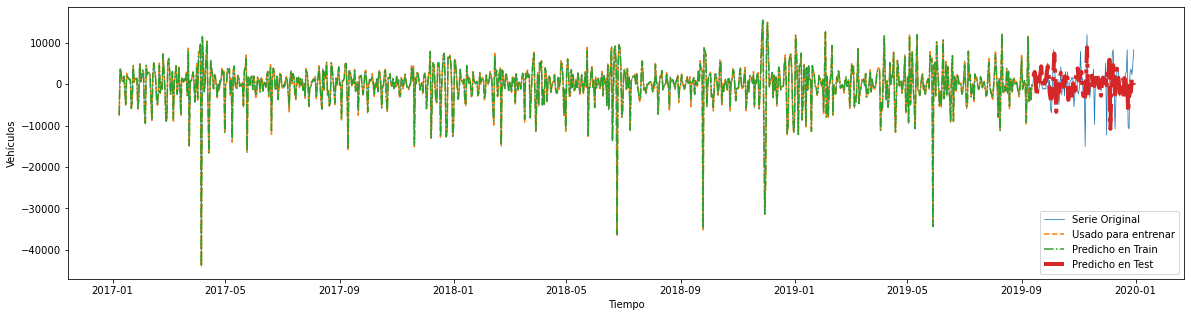

In [14]:
# Entrenamos un modelo XGB con valores predeterminados, como el proyecto 3, servirá de modelo benchmark

xgb = XGBRegressor(random_state=42, n_jobs = -1)
xgb.fit(X_train,y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Graficamos para comparar el comportamiento de los valores reales con los predichos por el modelo
plt.figure(figsize=(20,5))
plt.plot(dataset_sup.index, dataset_sup['cantidad_pasos'],lw = 0.75, label = 'Serie Original')
plt.plot(X_train.index, y_train,'--', label = 'Usado para entrenar')
plt.plot(X_train.index, y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(X_test.index, y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Vehículos')
plt.show()

In [15]:
# Utilizando la misma métrica que en el proyecto 3, obtenemos la evaluación del modelo para este caso.

MAE_train = mean_absolute_error(y_train, y_train_pred)
print('Error en Train:',MAE_train)

MAE_test = mean_absolute_error(y_test, y_test_pred)
print('Error en Test:',MAE_test)

Error en Train: 178.22529654572475
Error en Test: 2550.0386668085175


### Con el gráfico de la siguiente celda podemos visualizar que el modelo no le da mucha importancia a la nueva variable que agregamos. La mayor importancia se la da a la variable que representa 7 pasos en el pasado de la predicción, lo cuál justificamos con el análisis de frecuencias que se realizó al inicio.

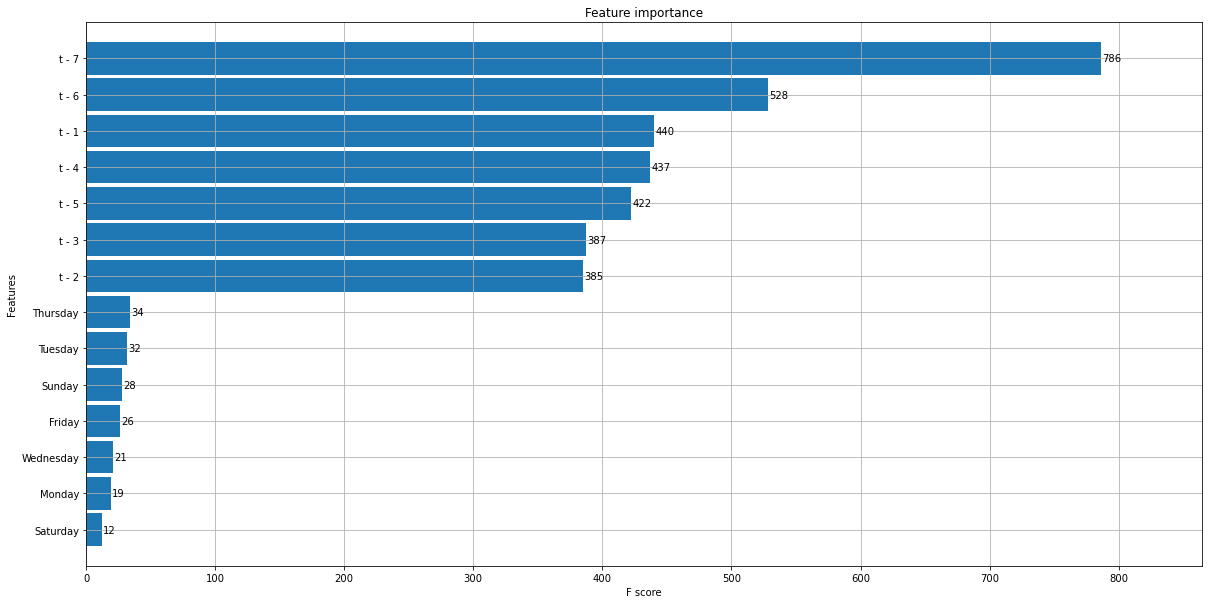

In [16]:
_ = plot_importance(xgb, height=0.9)

### Realizamos el mismo proceso, ahora con el mismo modelo XGB, pero con los hiperparámetros seleccionados como más óptimos en el proyecto 3, para verificar si hay una mejora de rendimiento en este caso.

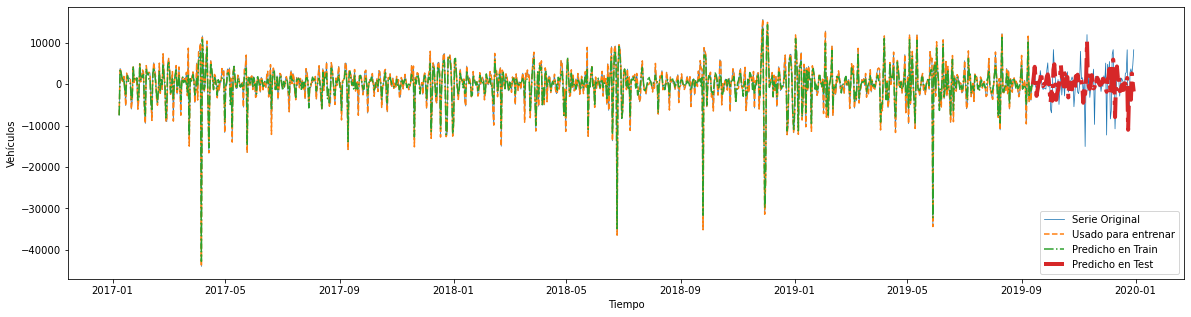

In [17]:
xgb_2 = XGBRegressor(random_state=42, n_jobs = -1, n_estimators = 1900, learning_rate = 0.003, reg_lambda = 0.0003)
xgb_2.fit(X_train,y_train)

y_train_pred = xgb_2.predict(X_train)
y_test_pred = xgb_2.predict(X_test)

plt.figure(figsize=(20,5))
plt.plot(dataset_sup.index, dataset_sup['cantidad_pasos'],lw = 0.75, label = 'Serie Original')
plt.plot(X_train.index, y_train,'--', label = 'Usado para entrenar')
plt.plot(X_train.index, y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(X_test.index, y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Vehículos')
plt.show()

In [18]:
MAE_train = mean_absolute_error(y_train, y_train_pred)
print('Error en Train:',MAE_train)

MAE_test = mean_absolute_error(y_test, y_test_pred)
print('Error en Test:',MAE_test)

Error en Train: 1121.6039033613167
Error en Test: 2481.33556284938


### Para concluir esta sección tenemos que:

* Proyecto 3:

    * MAE Test Modelo Benchmark: 2618.728
    * MAE Test Modelo Optimizado: **2383.112**

* Proyecto 4 (Actual):
    * MAE Test Modelo Benchmark: 2550.039
    * MAE Test Modelo Optimizado: 2481.336

El agregar el feature adicional que indica el día que se quiere predecir, no implica una mejora considerable en el desempeño del modelo. El modelo optimizado del Proyecto 3 sigue siendo mejor aún sin esa nueva característica que aquí agregamos, por lo que podemos concluir que agregar más features no siempre implica que el modelo funcionará mejor.

## 2.3 ¿Un modelo de Redes Neuronales tendrá mejor desempeño que el modelo final obtenido en el Proyecto 3? 

Se implementará un modelo sencillo de Redes Neuronales de la librería Tensorflow para realizar la comparación de rendimiento entre éste y el modelo final del Proyecto 3, el cuál sigue siendo el mejor hasta este punto.

### Deep Learning

In [19]:
# Se importan las librerías de Tensorflow a utilizar
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
# Tomamos nuestro dataset de la serie, el cual contiene únicamente como features los valores con retraso.
ds_dl = dataset_sup[input_columns + label_columns]
ds_dl

,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,cantidad_pasos
2017-01-08,-10445.125000,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635236
2017-01-09,3934.833984,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170724
2017-01-10,2075.587402,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199614
2017-01-11,2516.151855,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866133
2017-01-12,3835.887207,1993.365234,-6158.139160,-7459.635254,3823.170654,2890.199707,906.866150,648.887195
...,...,...,...,...,...,...,...,...
2019-12-26,352.458618,-1123.063354,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172910
2019-12-27,-1123.063354,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365217
2019-12-28,2520.860596,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365234,2304.289210
2019-12-29,2850.936279,8303.742188,-10288.657227,-10772.276367,2778.172852,3708.365234,2304.289307,4580.941295


In [21]:
# Preparamos los conjuntos de entrenamiento, validación y prueba del modelo.
X = ds_dl.drop(columns='cantidad_pasos').copy()
y = ds_dl['cantidad_pasos'].copy()

N = len(ds_dl)

N_train = int(N*0.9) # Cantidad de instancias que vamos a usar para entrenar.
N_val = int(N_train*0.2) # Muestras para validar el entrenamiento 
N_test = N - N_train # El restante son los meses a predecir (3 últimos meses del 2019)

length_total = N_train + N_test + input_width

X_train = X[:N_train - N_val]
y_train = y[:N_train - N_val]
print(X_train.shape, y_train.shape)

# Es importante preparar un conjunto de validación, ya que este se utiliza durante el entrenamiento del modelo de redes neuronales para optimizar el modelo a medida que se va entrenando.
X_val = X[N_train - N_val:N_train]
y_val = y[N_train - N_val:N_train]
print(X_val.shape, y_val.shape)

X_test = X[N_train:N_train+N_test]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(783, 7) (783,)
(195, 7) (195,)
(109, 7) (109,)


In [22]:
# Escalado de datos: Necesario en modelos de redes neuronales, para que algún feature no tome un peso mayor que otro por la escala de los datos.
std = StandardScaler()

# Realizamos el ajuste del Escalador únicamente con los datos de entrenamiento, transformamos sus valores.
X_train[input_columns] = std.fit_transform(X_train[input_columns])

# Transformamos el conjunto de validación.
X_val[input_columns] = std.transform(X_val[input_columns])

# Transformamos el conjunto de prueba.
X_test[input_columns] = std.transform(X_test[input_columns])

X_train.head()

ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ugom9\miniconda3\envs\Acamica-env\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\ugom9\miniconda3\envs\Acamica-env\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1
2017-01-08,-2.048628,0.772301,0.407522,0.494365,0.754883,0.393281,-1.211328
2017-01-09,0.772391,0.406619,0.494205,0.754040,0.392287,-1.211456,-1.467562
2017-01-10,0.407649,0.493270,0.753868,0.391500,-1.211874,-1.467674,0.753760
2017-01-11,0.494078,0.752840,0.391345,-1.212416,-1.468000,0.753504,0.570080
2017-01-12,0.752980,0.390447,-1.212493,-1.468502,0.752380,0.569836,0.179607


In [23]:
%%time

# Establecemos un valor de semilla para las librerias que manejen datos aleatórios, para poder reproducir los resultados en otras ocasiones.
np.random.seed(42) 
tf.random.set_seed(42)

# Definimos la estructura del modelo. En este caso será una red neuronal de 3 capas, con 33 neuronas cada una
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[X_train.shape[1]]), # La primera capa recibe la cantidad de Features del conjunto de entrenamiento
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # El modelo tendrá una única salida, que será el valor que se quiere predecir
  ])

optimizer = tf.keras.optimizers.RMSprop(0.001) # Establecemos una función de optimización para el modelo

# Compilamos el modelo indicando la función de pérdida, el algoritmo de optimización y la métrica con la que se evaluará
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])

# Imprimimos el resumen del modelo
model.summary()

# Entrenamos el modelo indicando la cantidad de iteraciones y los datos con los que se evalurá
history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_val, y_val), verbose = 1)

=============] - 0s 3ms/step - loss: 8826499.0000 - mae: 2098.8442 - val_loss: 16994198.0000 - val_mae: 2923.8208
Epoch 1872/2000
25/25 [==============================] - 0s 3ms/step - loss: 8832443.0000 - mae: 2101.2725 - val_loss: 17022954.0000 - val_mae: 2924.1704
Epoch 1873/2000
25/25 [==============================] - 0s 3ms/step - loss: 8832054.0000 - mae: 2101.0662 - val_loss: 17013922.0000 - val_mae: 2922.8779
Epoch 1874/2000
25/25 [==============================] - 0s 3ms/step - loss: 8825638.0000 - mae: 2100.1926 - val_loss: 17042334.0000 - val_mae: 2923.7510
Epoch 1875/2000
25/25 [==============================] - 0s 3ms/step - loss: 8824727.0000 - mae: 2100.4480 - val_loss: 17067182.0000 - val_mae: 2924.0884
Epoch 1876/2000
25/25 [==============================] - 0s 3ms/step - loss: 8829251.0000 - mae: 2099.4509 - val_loss: 17062162.0000 - val_mae: 2923.5212
Epoch 1877/2000
25/25 [==============================] - 0s 3ms/step - loss: 8828005.0000 - mae: 2099.2297 - val_los

In [24]:
# Guardamos el historial del entrenamiento en una DataFrame para futuras referencias
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
1995,8713417.0,2087.705811,16893266.0,2921.503418,1995
1996,8709764.0,2085.770508,16896376.0,2922.108887,1996
1997,8718424.0,2087.381592,16907928.0,2921.356689,1997
1998,8709525.0,2085.850830,16872122.0,2920.860840,1998
1999,8709621.0,2085.806396,16874658.0,2922.968506,1999


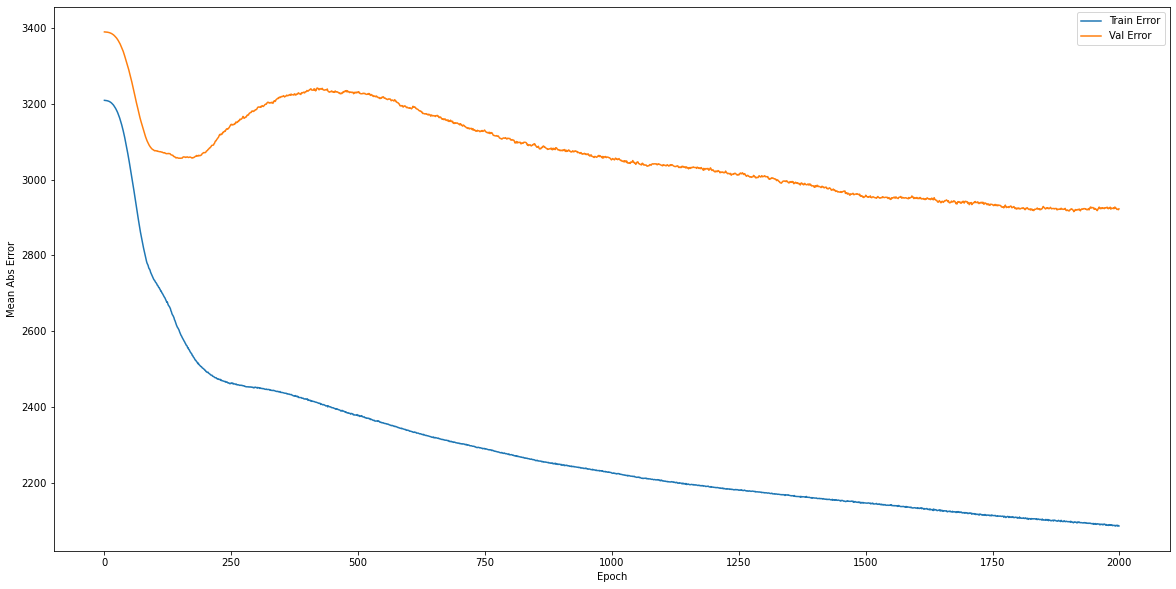

In [25]:
# Función que muestra la gráfica del comportamiento del rendimiento en cada iteración del entrenamiento del modelo
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.legend()


plot_history(history)

En el gráfico anterior, podemos observar cómo se comporta el MAE a lo largo de las 2000 iteraciones del modelo. Es muy útil para tener una idea de si nuestra configuración de modelo va teniendo un buen aprendizaje de los datos a lo largo del proceso y tener una idea del alcance que puede tener.

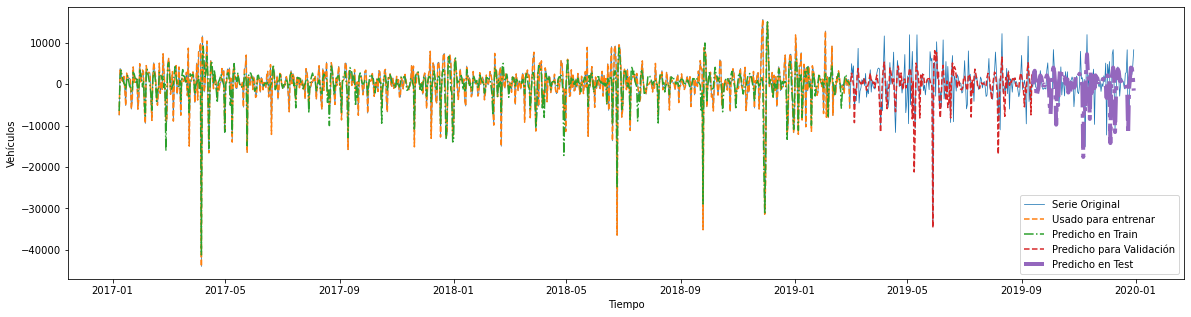

In [26]:
# Pintamos el gráfico comparativo de los datos reales de la serie con los valores predichos por el modelo en cada conjunto.
y_train_pred = model.predict(X_train).flatten()
y_val_pred = model.predict(X_val).flatten()
y_test_pred = model.predict(X_test).flatten()

plt.figure(figsize=(20,5))
plt.plot(dataset_sup.index, dataset_sup['cantidad_pasos'],lw = 0.75, label = 'Serie Original')
plt.plot(X_train.index, y_train,'--', label = 'Usado para entrenar')
plt.plot(X_train.index, y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(X_val.index, y_val_pred,'--', label = 'Predicho para Validación')
plt.plot(X_test.index, y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Vehículos')
plt.show()

En el gráfico comparativo de la celda anterior podemos observar que el modelo presenta un buen comportamiento en la predicción de datos, aunque no es tan precisa como se desearía, el modelo no se desvía mucho de la realidad.

In [27]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

4/4 - 0s - loss: 14122364.0000 - mae: 2658.6252
Testing set Mean Abs Error: 2658.63


El cálculo del MAE para este modelo de Redes Neuronales nos arroja de 2658.36, lo cúal es más alto que el modelo final implementado en el proyecto 3 (MAE Modelo Optimizado Proyecto 3: 2383.112). Hasta este momento, el del proyecto 3 sigue siendo mejor modelo.

Este resultado se puede deber a que para la implementación de esta red neuronal se seleccionaron valores arbitrarios para sus hiperparámetros (33 neuronas y un optimizador por RMS).

Vamos a probar el mismo modelo, pero con cantidades diferentes de neuronas para buscar mejorar su desempeño.

In [28]:
%%time

# Creamos un arreglo en donde almacenaremos los datos de cada iteración
mae_arr = []

# En cada iteración se va a cambiar la cantidd de neuronas en cada capa del modelo.
for i in np.arange(10,95,5):

    model = keras.Sequential([
      layers.Dense(i, activation='relu', input_shape=[X_train.shape[1]]),
      layers.Dense(i, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001) # Se utilizará el mismo optimizador que el modelo anterior

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_val, y_val), verbose = 0)

    loss, mae = model.evaluate(X_test, y_test, verbose=0)

    # Guardamos los resultados para cada iteración
    mae_arr.append((i,mae))

    print((i,mae))

mae_arr = pd.DataFrame(mae_arr, columns=['Neuronas', 'MAE_Test'])

(10, 2605.611572265625)
(15, 2598.632568359375)
(20, 2565.49609375)
(25, 2540.88525390625)
(30, 2588.117431640625)
(35, 2690.849853515625)
(40, 2655.279296875)
(45, 2653.256103515625)
(50, 2670.9990234375)
(55, 2608.24365234375)
(60, 2702.559326171875)
(65, 2670.9326171875)
(70, 2657.86376953125)
(75, 2764.576171875)
(80, 2783.195068359375)
(85, 2729.646240234375)
(90, 2669.3759765625)
Wall time: 32min 17s


In [29]:
# Mostramos el desempeño del modelo para cada iteracion. Se muestra que el modelo funciona mejor con 25 neuronas.
mae_arr.sort_values(by='MAE_Test').head()

,Neuronas,MAE_Test
3,25,2540.885254
2,20,2565.496094
4,30,2588.117432
1,15,2598.632568
0,10,2605.611572


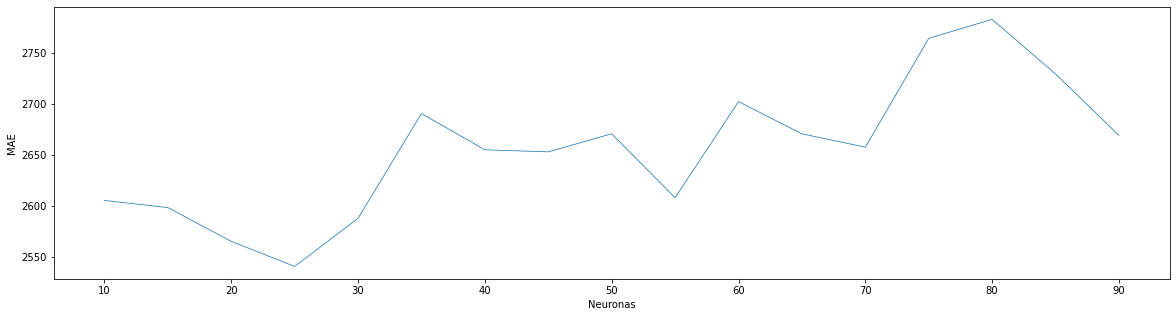

In [30]:
# Gráfico de desempeño del modelo para cada cantidad de neuronas asignado
plt.figure(figsize=(20,5))
plt.plot(mae_arr['Neuronas'],mae_arr['MAE_Test'],lw = 0.75)
plt.xlabel('Neuronas')
plt.ylabel('MAE')
plt.show()

Ya que encontramos que la cantidad óptima de neuronas para nuestro modelo es de 25, probaremos con diferentes algoritmos de optimización para mejorar el desempeño.

In [31]:
%%time

# Creamos un arreglo en donde almacenaremos los datos de cada iteración
mae_arr_op = []

# Array de optimizadores candidatos
optimizadores = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

# Iteramos sobre los optimizadores candidatos para encontrar el mejor
for opt in optimizadores:

    model = keras.Sequential([
      layers.Dense(25, activation='relu', input_shape=[X_train.shape[1]]),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mse',
                  optimizer=opt,
                  metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_val, y_val), verbose = 0)

    loss, mae = model.evaluate(X_test, y_test, verbose=0)

    mae_arr_op.append((opt,mae))

    print((opt,mae))

mae_arr_op = pd.DataFrame(mae_arr_op, columns=['Optimizador', 'MAE_Test'])

('RMSprop', 2598.080078125)
('Adagrad', 3051.3837890625)
('Adadelta', 3062.948486328125)
('Adam', 2585.60888671875)
('Adamax', 2768.43701171875)
('Nadam', 2597.6015625)
Wall time: 10min 40s


In [32]:
# Mostramos los resuldados en donde podemos ver en primer lugar al optimizador que presentó mejor desempeño
mae_arr_op.sort_values(by='MAE_Test').head()

,Optimizador,MAE_Test
3,Adam,2585.608887
5,Nadam,2597.601562
0,RMSprop,2598.080078
4,Adamax,2768.437012
1,Adagrad,3051.383789


<AxesSubplot:xlabel='Optimizador', ylabel='MAE_Test'>

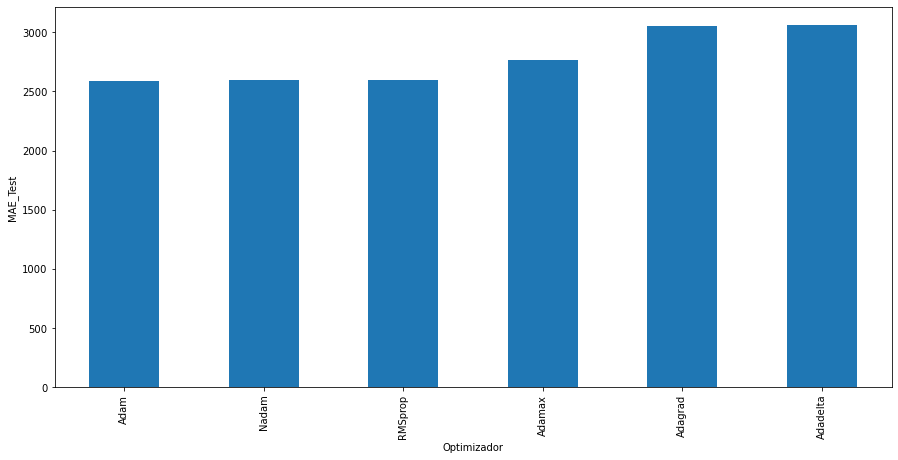

In [33]:
# Graficamos los resultado para hacer una comparación más visual
mae_arr_op.sort_values(by='MAE_Test').plot(x = 'Optimizador', y = 'MAE_Test', kind = 'bar', legend = False, ylabel = 'MAE_Test', figsize = (15,7) )

## Conclusión final.

A partir del proyecto 3 se realizaron 3 ejercicios:

* Se justificó con un análisis de frecuencias el porqué debemos considerar 7 días en el pasado para realizar una predicción para este ejercicio.
* Se consideró una feature más para intentar mejorar el desempeño de los modelos del proyecto 3.
* Se implementó un modelo sencillo de redes neuronales con el objetivo de tener un mejor desempeño en la predicción que el modelo final del proyecto 3.

En general, los tres puntos dejaron buena experiencia sobre el proceso que conlleva el querer mejorar el desempeño de una predicción, en la busqueda de un mejor modelo. 

Para el caso de este proyecto, esperaba tener mejores resultados implementando nuevos modelos o agregando más características de predicción, pero no fue así. Los resultados del modelo final implementando en el proyecto 3 siguen siendo mejor que los que se trabajaron aquí. Y la enseñanza es esa, que tanto nos enseñaron en la cursada. Implementar un modelo más complejo no significa siempre mejores resultados. 

Aunque tal vez me ví limitado por la curva de aprendizaje por el uso de una nueva librería, considero que valió mucho el realizar este ejercicio y haber obtenido estos resultados, para estar convencido de que lo más complejo no siempre es lo mejor.

Link al repositorio: https://github.com/ugom93/Acamica